# Overview

We will construct a PyTorch `Data` object for homogeeous graph data, and then train different types of neural networks to predict what class a node belongs to.


# Loading dataset

* `musage_facebook_edges.csv`: This file contains the graph of connections between Facebook pages with two columns-target nodes from the `id_1` column and destination nodes from the `id_2` column.

* `musae_facebook_target.csv`: This file contains the descriptions and page type of the 22470 Facebook pages in the dataset. The label that we are trying to predict is the `page_type` column, which is a multi-class label that categorizes each Facebook page into one of four classes.

* `musae_facebook_features.json`: This file contains the feature vectors for each Facebook page. The key is the node `id` and values are feature vectors.

In [11]:
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.1.2+cpu


In [12]:
!pip install -q -U torch_geometric==2.5.3

In [2]:
import urllib.request
import zipfile

# Specify link
url = "https://snap.stanford.edu/data/facebook_large.zip"

# Specify directory to save file
save_path = "./data/facebook_large.zip"
data_dir = "./data/facebook_large"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Download file
urllib.request.urlretrieve(url, save_path)

# Extract file
with zipfile.ZipFile(save_path, "r") as zip_ref:
    zip_ref.extractall(path=os.path.dirname(save_path))

# EDA dataset

In [21]:
# Import edges file as a dataframe
df_edges = pd.read_csv(
    os.path.join(data_dir, "musae_facebook_edges.csv"),
).rename(columns={"id_1": "fb_site_id", "id_2": "follower_fb_site_id"})

print(df_edges.shape)
df_edges.head()

(171002, 2)


,fb_site_id,follower_fb_site_id
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [22]:
df_target = pd.read_csv(
    os.path.join(data_dir, "musae_facebook_target.csv"),
)

print(df_target.shape)
df_target.head()

(22470, 4)


,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [23]:
len(set(df_edges.fb_site_id.tolist() + df_edges.follower_fb_site_id.tolist()))

22470

In [24]:
df_agg_classes = pd.DataFrame(df_target.page_type.value_counts(normalize=True)).reset_index()
df_agg_classes

,page_type,proportion
0,government,0.306186
1,company,0.289052
2,politician,0.256698
3,tvshow,0.148064


# Preparing the dataset

## Creating a PyTorch Homegenous Data Obejct from CSV

We need to create a data obbject for training a neural network in PyTorch. Since the dataset contains all nodes of the same type: i.e: papers, we will create a `Data` object describing a homegeneous graph. For the dataset contains nodes or edges of multiple types, we will need to create a `HeteroData` data object describling a heterogeneous graph.

In [7]:
import pandas as pd
import json

import torch
from torch.nn.utils.rnn import pad_sequence

def load_node_csv(path, index_col, **kwargs):
    df = pd.read_csv(path, **kwargs)
    mapping = {i: node_id for i, node_id in enumerate(df[index_col].unique())}

    # Load node features
    with open(os.path.join(data_dir, "musae_facebook_features.json"), "r") as json_file:
        features_data = json.load(json_file)

    xs = []
    for index, node_id in mapping.items():
        features = features_data.get(str(index), [])
        if features:
            # Create tensor from feature vector
            features_tensor = torch.tensor(features, dtype=torch.float)
            xs.append(features_tensor)
        else:
            xs.append(torch.zeros(1, dtype=torch.float))
    
    # Pad features to have vectors of the same size
    padded_features = pad_sequence([torch.tensor(seq) for seq in xs], batch_first=True, padding_value=0)
    mask = padded_features != 0 # mask to indicate which features were padded
  
    # Create tensor of normaized features for nodes
    mean = torch.mean(padded_features[mask].float())
    std = torch.std(padded_features[mask].float())

    x = (padded_features - mean) / (std + 1e-8)  # final x tensor with normalized features

    return x

x = load_node_csv(path=os.path.join(data_dir, "musae_facebook_target.csv"), index_col="facebook_id")
# x containing the PyTorch tensors containing feature vectors of the 22,470 Facebook pages.
x.shape

/tmp/ipykernel_33/3231665264.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_features = pad_sequence([torch.tensor(seq) for seq in xs], batch_first=True, padding_value=0)


torch.Size([22470, 31])

## Loading labels data

After creating nodes, we will create the `y` tensors for the label that the model will predict on. Do not forget we need to convert these labels into intergers in order to be able to create PyTorch Tensors for thie variable.

In [8]:
def load_labels_csv(path, label_col, **kwargs):
    df = pd.read_csv(path, **kwargs)

    # Convert class_labels to numeric data types in order to create tensors
    label_categories = df[label_col].astype("category").cat.categories

    class_label_to_code = pd.DataFrame({
        "class_label": label_categories,
        "class_label_code": pd.Categorical(label_categories, categories=label_categories).codes
    })

    df["class_label_code"] = pd.Categorical(df[label_col], categories=label_categories).codes

    y = torch.tensor(df["class_label_code"].values, dtype=torch.long)

    return y

y = load_labels_csv(path=os.path.join(data_dir, "musae_facebook_target.csv"), label_col="page_type")
# a PyTorch tensor for the 22,470 Facebook pages containing the page_type label in the dataset.
y.shape

torch.Size([22470])

## Loading the edges Data

The final step of this data preparation step is to load in data on edges between nodes in the graph.

In [9]:
def load_edge_csv(path, src_index_col, dst_index_col, **kwargs):
    df = pd.read_csv(path, **kwargs)

    src = df[src_index_col].values
    dst = df[dst_index_col].values
    edge_index = torch.tensor([src, dst])

    return edge_index

edge_index = load_edge_csv(path=os.path.join(data_dir, "musae_facebook_edges.csv"), src_index_col="id_1", dst_index_col="id_2")
# edge_index is a tensor of length two, one for the source node and the other for the target node
edge_index.shape

/tmp/ipykernel_33/3300055113.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  edge_index = torch.tensor([src, dst])


torch.Size([2, 171002])

## Creating homogeneous graph data object

In [15]:
from torch_geometric.data import Data

data=Data(x=x, edge_index=edge_index, y=y)
data

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470])

## Splitting data

We split my dataset into 70% for training and 30% for testing.

In [26]:
num_nodes=data.num_nodes
train_percentage=0.7
num_train_nodes=int(train_percentage * num_nodes)

num_classes=torch.unique(data.y).size(0)
data.num_classes=num_classes

# create a boolean mask for train mask
train_mask=torch.zeros(num_nodes, dtype=torch.bool)
train_mask[: num_train_nodes]=True

data.train_mask=train_mask

# create a boolean mask for test mask
test_mask=~data.train_mask
data.test_mask=test_mask

data

Data(x=[22470, 31], edge_index=[2, 171002], y=[22470], train_mask=[22470], test_mask=[22470], num_classes=4)

# Training Multi-layer Perception Network(MLP)

The first model we will train is a multi-layer perception network. It is a type of feedforward neural network with multiple layers, meaning that information flows forward in one direction, from input to output.

In [27]:
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        self.lin1=Linear(data.num_features, 32)
        self.lin2=Linear(32,32)
        self.lin3 = Linear(32, 16)
        self.lin4 = Linear(16, 8)
        self.lin5 = Linear(8, data.num_classes)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        x = F.relu(x)
        x = self.lin4(x)
        x = F.relu(x)
        x = self.lin5(x)
        x = torch.softmax(x, dim=1)

        return x
    
    
# we define class_weights parameter here to be inversely proportional to the proportion of classes
# in the dataset to help the model training process.
class_weights = torch.tensor([1 / i for i in df_agg_classes["proportion"].values], dtype=torch.float)

model = MLP()

# loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# It is used in the backpropagration process.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model

# Visualization nodes and labels

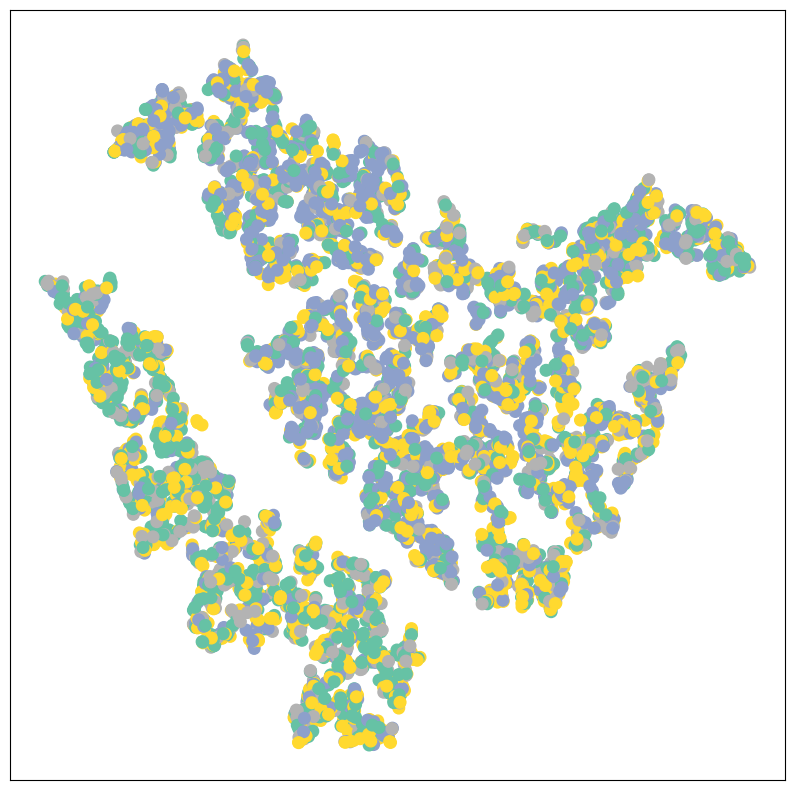

In [31]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z=TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

model.eval()
out=model(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

In [33]:
def train():
    model.train()
    optimizer.zero_grad()   # Clear gradients
    out = model(data.x)   # Perform a single forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])   # Compute loss solely based on training nodes
    loss.backward()   # Derive gradients
    optimizer.step()    # Update parameters based on gradients
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use class with highest probability

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_correct = pred[data.test_mask] == data.y[data.test_mask]   # Check against ground-truth labels
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Calculate ratio of correct predictions
    return test_acc


for epoch in range(1, 1001):
    loss = train()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 100, Loss: 1.3213
Epoch: 200, Loss: 1.2978
Epoch: 300, Loss: 1.2899
Epoch: 400, Loss: 1.2875
Epoch: 500, Loss: 1.2713
Epoch: 600, Loss: 1.2652
Epoch: 700, Loss: 1.2639
Epoch: 800, Loss: 1.2597
Epoch: 900, Loss: 1.2623
Epoch: 1000, Loss: 1.2642


{0: 2139, 1: 2367, 2: 1093, 3: 1143}
Test accuracy: 0.4577


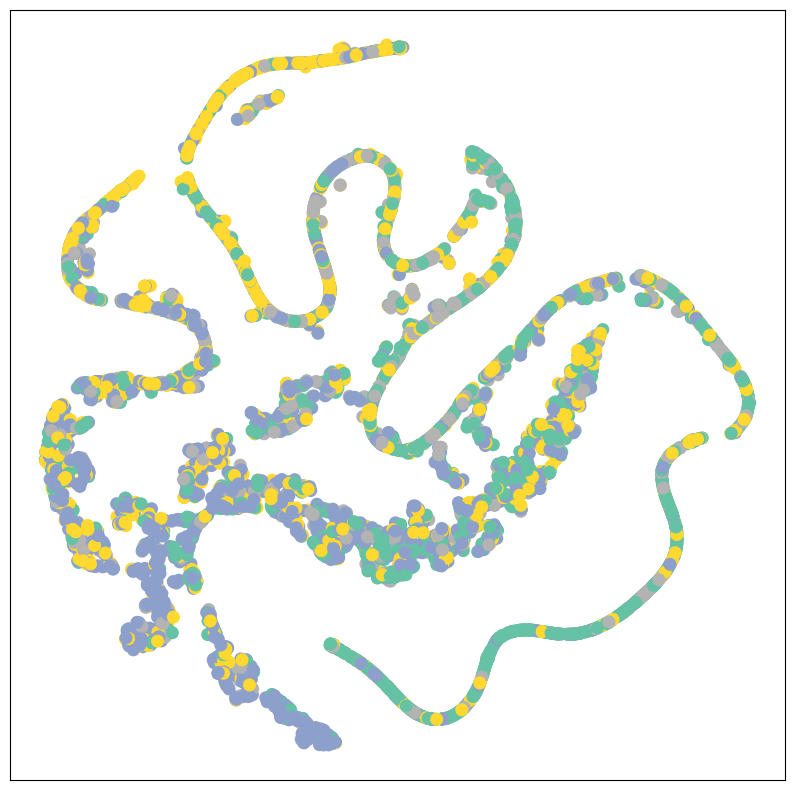

In [34]:
test_acc=test()
print(f"Test accuracy: {test_acc:.4f}")

model.eval()
out=model(data.x)
visualize(out[data.test_mask], color=data.y[data.test_mask])

# Train Graph Neural Network(GNN)

In [35]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GCNConv(data.num_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, 8)
        self.conv5 = GCNConv(8, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.8)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.8)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

model = GCN()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model

GCN(
  (conv1): GCNConv(31, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 8)
  (conv5): GCNConv(8, 4)
)

In [36]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc
    

for epoch in range(1, 1001):
    loss = train()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 100, Loss: 1.1142
Epoch: 200, Loss: 0.9949
Epoch: 300, Loss: 0.9648
Epoch: 400, Loss: 0.8409
Epoch: 500, Loss: 0.8089
Epoch: 600, Loss: 0.7628
Epoch: 700, Loss: 0.7478
Epoch: 800, Loss: 0.7524
Epoch: 900, Loss: 0.6890
Epoch: 1000, Loss: 0.6703


{0: 1654, 1: 2224, 2: 1635, 3: 1229}
Test Accuracy: 0.7852


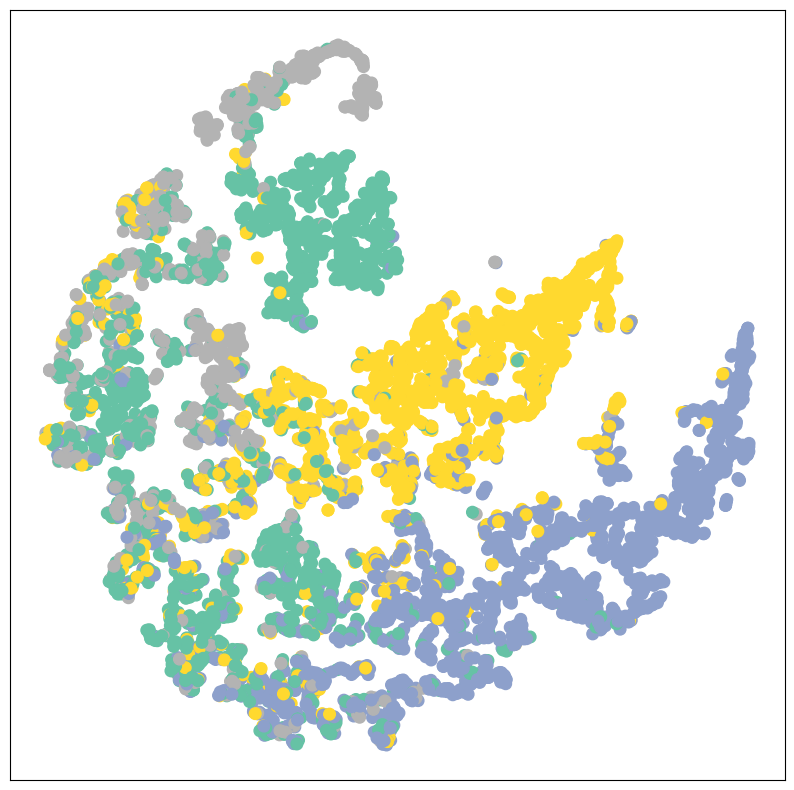

In [37]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

model.eval()
out = model(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

# Train a Graph Attention Network (GATConv)

In [38]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GATConv(in_channels=data.num_features, out_channels=32, heads=32)
        self.conv2 = GATConv(in_channels=32 * 32, out_channels=16, heads=16)
        self.conv3 = GATConv(in_channels=16 * 16, out_channels=8, heads=8)
        self.conv4 = GATConv(in_channels=8 * 8, out_channels=4, heads=4)
        self.conv5 = GATConv(in_channels=4 * 4, out_channels=data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.softmax(x, dim=1)
        return x
    
model = GAT()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model     

GAT(
  (conv1): GATConv(31, 32, heads=32)
  (conv2): GATConv(1024, 16, heads=16)
  (conv3): GATConv(256, 8, heads=8)
  (conv4): GATConv(64, 4, heads=4)
  (conv5): GATConv(16, 4, heads=1)
)

In [39]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    # Count the number of predictions for each class
    class_counts = {}
    for class_label in range(data.num_classes):
        class_counts[class_label] = int((pred == class_label)[data.test_mask].sum())

    print(class_counts)

    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 101):
    loss = train()
    test_acc = test()
    if epoch % 100 ==0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}")

{0: 80, 1: 6473, 2: 189, 3: 0}
{0: 0, 1: 0, 2: 6742, 3: 0}
{0: 208, 1: 1411, 2: 5123, 3: 0}
{0: 927, 1: 5038, 2: 777, 3: 0}
{0: 1576, 1: 5166, 2: 0, 3: 0}
{0: 1326, 1: 5301, 2: 115, 3: 0}
{0: 1232, 1: 4855, 2: 654, 3: 1}
{0: 1751, 1: 4184, 2: 791, 3: 16}
{0: 1612, 1: 4380, 2: 269, 3: 481}
{0: 1153, 1: 5024, 2: 37, 3: 528}
{0: 1665, 1: 4489, 2: 68, 3: 520}
{0: 1854, 1: 4225, 2: 99, 3: 564}
{0: 1271, 1: 4840, 2: 28, 3: 603}
{0: 2379, 1: 3673, 2: 81, 3: 609}
{0: 1462, 1: 4758, 2: 4, 3: 518}
{0: 1757, 1: 4449, 2: 34, 3: 502}
{0: 2516, 1: 3282, 2: 353, 3: 591}
{0: 1336, 1: 4948, 2: 35, 3: 423}
{0: 1866, 1: 4291, 2: 71, 3: 514}
{0: 2212, 1: 3368, 2: 418, 3: 744}
{0: 1455, 1: 4408, 2: 239, 3: 640}
{0: 1716, 1: 4095, 2: 399, 3: 532}
{0: 2129, 1: 3227, 2: 905, 3: 481}
{0: 1805, 1: 4233, 2: 394, 3: 310}
{0: 1250, 1: 3368, 2: 1740, 3: 384}
{0: 1190, 1: 4211, 2: 1023, 3: 318}
{0: 1198, 1: 3028, 2: 2215, 3: 301}
{0: 1421, 1: 4093, 2: 989, 3: 239}
{0: 837, 1: 3334, 2: 2199, 3: 372}
{0: 550, 1: 3698,

{0: 1319, 1: 2460, 2: 2303, 3: 660}
Test Accuracy: 0.5848


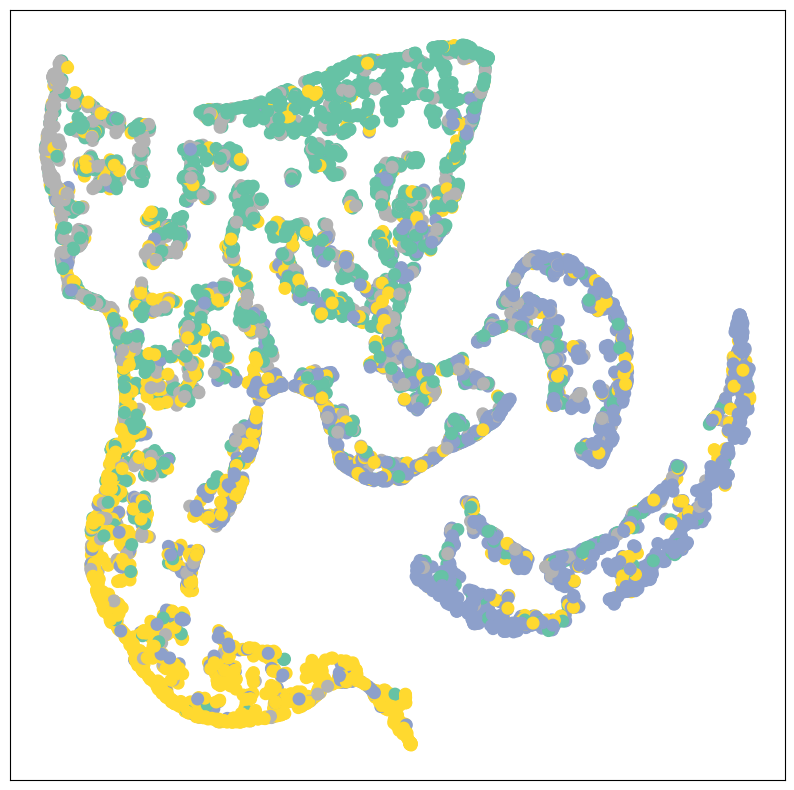

In [40]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")


model.eval()
out = model(data.x, data.edge_index)
visualize(out[data.test_mask], color=data.y[data.test_mask])

# Acknowledge

* https://snap.stanford.edu/data/facebook-large-page-page-network.html
* https://towardsdatascience.com/how-to-build-neural-networks-for-node-classification-from-tabular-data-bdd07ceaef83
* https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html
* https://github.com/claudian37/DS_Portfolio/blob/master/neural_networks/2_node_classification_facebook_dataset_may2024.ipynb